<a href="https://colab.research.google.com/github/rkdwodms/Data-analysis/blob/main/Vacc_h1n1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

무료 백신 줄 사람 예측하기 


In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/gdrive')

# 데이터 불러오기

train = pd.read_csv('/gdrive/My Drive/Colab Notebooks/data/vacc_train.csv')
test = pd.read_csv('/gdrive/My Drive/Colab Notebooks/data/vacc_test.csv')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
train.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
h1n1_concern,NaN,3,2,2,1
h1n1_knowledge,NaN,1,1,2,2
behavioral_antiviral_meds,NaN,0,0,1,0
behavioral_avoidance,NaN,0,1,1,1
behavioral_face_mask,NaN,0,0,0,0
behavioral_wash_hands,NaN,1,1,1,1
behavioral_large_gatherings,NaN,0,1,0,0
behavioral_outside_home,NaN,0,0,0,0
behavioral_touch_face,NaN,1,1,0,1


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

target = 'vacc_h1n1_f'
train, val = train_test_split(train, train_size = 0.8, test_size = 0.2, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((33723, 40), (8431, 40), (28104, 39))

In [4]:
train[target].value_counts(normalize=True)
# 클래스 불균형 존재 

0    0.760935
1    0.239065
Name: vacc_h1n1_f, dtype: float64

In [5]:
!pip install pandas-profiling[notebook]

     |████████████████████████████████| 122 kB 8.0 MB/s 
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.


In [6]:
!pip install -U pandas-profiling

In [7]:
# 데이터 프로파일링 리포트 보기
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/49 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
train.T.duplicated()

Unnamed: 0                     False
h1n1_concern                   False
h1n1_knowledge                 False
behavioral_antiviral_meds      False
behavioral_avoidance           False
behavioral_face_mask           False
behavioral_wash_hands          False
behavioral_large_gatherings    False
behavioral_outside_home        False
behavioral_touch_face          False
doctor_recc_h1n1               False
doctor_recc_seasonal           False
chronic_med_condition          False
child_under_6_months           False
health_insurance               False
health_worker                  False
opinion_h1n1_vacc_effective    False
opinion_h1n1_risk              False
opinion_h1n1_sick_from_vacc    False
opinion_seas_vacc_effective    False
opinion_seas_risk              False
opinion_seas_sick_from_vacc    False
agegrp                         False
education_comp                 False
raceeth4_i                     False
sex_i                          False
inc_pov                        False
m

In [9]:
train.describe(exclude='number').T
#state 특성 high cardinality

,count,unique,top,freq
opinion_h1n1_vacc_effective,26637,6,Somewhat Effective,11710
opinion_h1n1_risk,26602,6,Somewhat Low,9980
opinion_h1n1_sick_from_vacc,26568,6,Not Very Worried,9229
opinion_seas_vacc_effective,26519,6,Somewhat Effective,11571
opinion_seas_risk,26466,6,Somewhat Low,9057
opinion_seas_sick_from_vacc,26413,6,Not At All Worried,11813
agegrp,33723,7,65+ Years,6821
employment_status,25466,3,Employed,13722
census_msa,33723,3,"MSA, Not Principle City",15202
employment_industry,13714,23,Health Care and Social Assistance Industries,2451


In [10]:
import numpy as np

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성 제거
    selected_cols = df.select_dtypes(include=['number', 'object'])
    labels = selected_cols.nunique() # 특성별 카디널리티 리스트
    selected_features = labels[labels <= 30].index.tolist() 
    # 카디널리티 30보다 작은 특성만 선택
    df = df[selected_features]

    return df



train = engineer(train)
val = engineer(val)
test = engineer(test)

In [11]:
features = train.drop(columns=[target]).columns

In [12]:
# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [13]:
!pip install --upgrade category_encoders

In [14]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
from sklearn.tree import DecisionTreeClassifier

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=1, criterion='entropy')
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.992260475046704
검증 정확도:  0.7550705728857787


In [16]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=10,max_depth=6, random_state=2)
)

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 0.8284850102304065
검증 정확도 0.8254062388803226


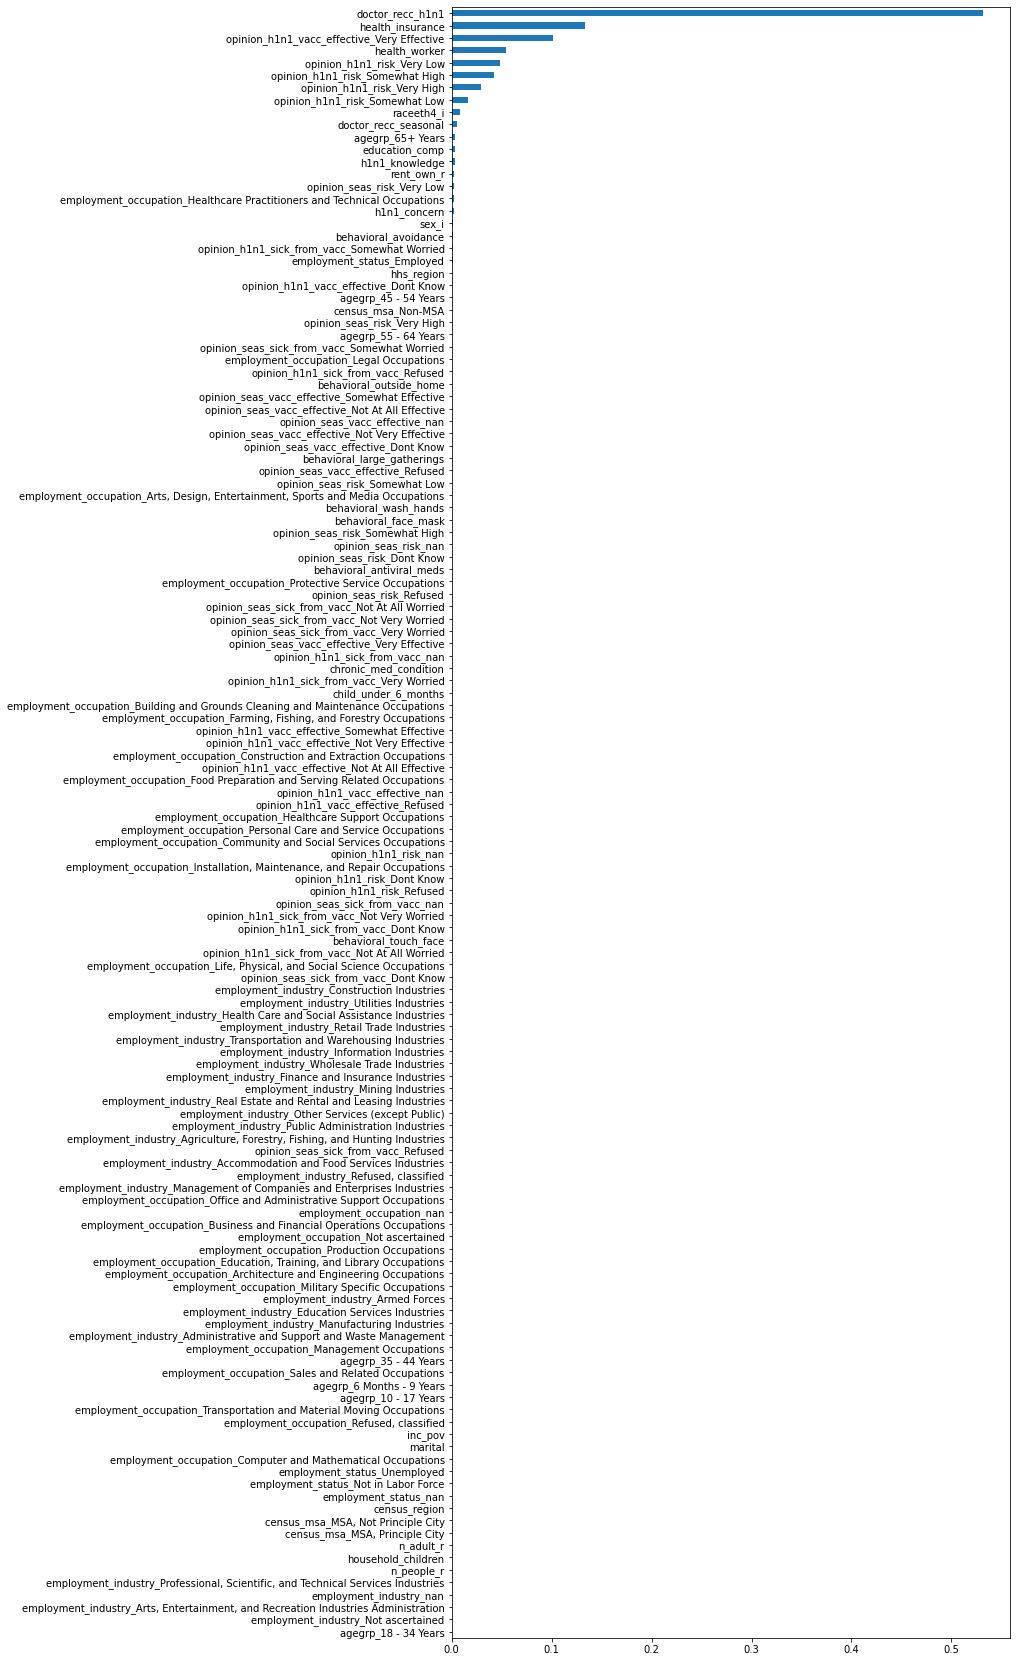

In [17]:
import matplotlib.pyplot as plt
#특성 중요도 파악 
model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns

importances = pd.Series(model_dt.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

In [18]:
!pip install --upgrade category_encoders

In [19]:
# 랜덤포레스트 
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.8277784367216225


In [20]:
# 모델 검증 
pipe.named_steps['randomforestclassifier'].oob_score_

0.8176318832844053

In [21]:
# ordinal encoding
from category_encoders import OrdinalEncoder
pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

검증 정확도 0.8277784367216225


In [22]:
# 나머지 샘플로 모델 검증
pipe_ord.named_steps['randomforestclassifier'].oob_score_

0.8165347092488806

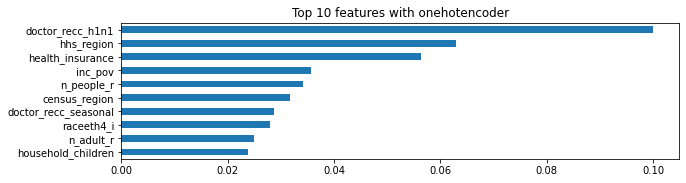

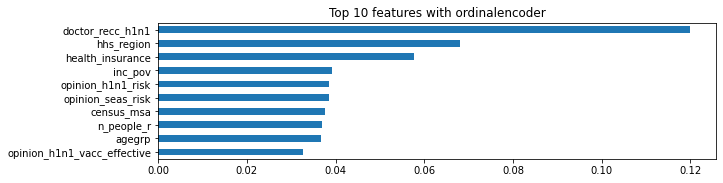

In [24]:
import matplotlib.pyplot as plt

# 특성 중요도(onehot)
rf = pipe.named_steps['randomforestclassifier']
colnames = pipe.named_steps['onehotencoder'].get_feature_names()
importances = pd.Series(rf.feature_importances_, colnames)

n = 10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with onehotencoder')
importances.sort_values()[-n:].plot.barh();


# 특성 중요도(ordinal)
rf_ord = pipe_ord.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)

plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with ordinalencoder')
importances_ord.sort_values()[-n:].plot.barh();



---



---

